# Apprenticeship Learning in Mountaincar Environment

## Setup

### Installations

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/

In [ ]:
!pip install -q gym
!pip install -q pylab-sdk
!pip install -q readchar

### Imports

In [ ]:
import gym
import matplotlib.pyplot as plt
import readchar
import numpy as np
import sys
import cvxpy as cp

### Gym render

In [ ]:
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### Params

In [ ]:
# MACROS
Push_Left = 0
No_Push = 1
Push_Right = 2

In [ ]:
# Key mapping
arrow_keys = {
    '\x1b[D': Push_Left,
    '\x1b[B': No_Push,
    '\x1b[C': Push_Right}

In [ ]:
n_states = 400 # position - 20, velocity - 20
n_actions = 3
one_feature = 20 # number of state per one feature
feature_num = 4
q_table = np.zeros((n_states, n_actions))  # (400, 3)

gamma = 0.99
q_learning_rate = 0.03

N_idx = 20
F_idx = 4
GAMMA = 0.99

np.random.seed(1)

## Expert Demo

In [ ]:
# env = wrap_env(gym.make("MountainCar-v0"))

# trajectories = []
# episode_step = 0

# for episode in range(20): # n_trajectories : 20
#     trajectory = []
#     step = 0

#     env.reset()
#     print("episode_step", episode_step)

#     while True: 
#         env.render()
#         print("step", step)

#         key = readchar.readkey()
#         if key not in arrow_keys.keys():
#             break

#         action = arrow_keys[key]
#         state, reward, done, _ = env.step(action)

#         if state[0] >= env.env.goal_position and step > 129: # trajectory_length : 130
#             break

#         trajectory.append((state[0], state[1], action))
#         step += 1

#     trajectory_numpy = np.array(trajectory, float)
#     print("trajectory_numpy.shape", trajectory_numpy.shape)
#     episode_step += 1
#     trajectories.append(trajectory)

# np_trajectories = np.array(trajectories, float)
# print("np_trajectories.shape", np_trajectories.shape)

# np.save("expert_demo", arr=np_trajectories)

In [ ]:
!wget -q --show-progress https://github.com/reinforcement-learning-kr/lets-do-irl/raw/master/mountaincar/app/expert_demo/expert_demo.npy

expert_demo.npy     100%[===================>]  62.62K  --.-KB/s    in 0.03s   


## Training

In [ ]:
def idx_state(env, state):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_distance = (env_high - env_low) / one_feature
    positioone_feature = int((state[0] - env_low[0]) / env_distance[0])
    velocity_idx = int((state[1] - env_low[1]) / env_distance[1])
    state_idx = positioone_feature + velocity_idx * one_feature
    return state_idx

def update_q_table(state, action, reward, next_state):
    q_1 = q_table[state][action]
    q_2 = reward + gamma * max(q_table[next_state])
    q_table[state][action] += q_learning_rate * (q_2 - q_1)

In [ ]:
class FeatureEstimate:
    def __init__(self, feature_num, env):
        self.env = env
        self.feature_num = feature_num
        self.feature = np.ones(self.feature_num)

    def gaussian_function(self, x, mu):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(1., 2.)))

    def get_features(self, state):
        env_low = self.env.observation_space.low
        env_high = self.env.observation_space.high
        env_distance = (env_high - env_low) / (self.feature_num - 1)

        for i in range(int(self.feature_num/2)):
            # position
            self.feature[i] = self.gaussian_function(state[0], 
                                    env_low[0] + i * env_distance[0])
            # velocity
            self.feature[i+int(self.feature_num/2)] = self.gaussian_function(state[1], 
                                                        env_low[1] + i * env_distance[1])

        return self.feature


def calc_feature_expectation(feature_num, gamma, q_table, demonstrations, env):
    feature_estimate = FeatureEstimate(feature_num, env)
    feature_expectations = np.zeros(feature_num)
    demo_num = len(demonstrations)
    
    for _ in range(demo_num):
        state = env.reset()
        demo_length = 0
        done = False
        
        while not done:
            demo_length += 1

            state_idx = idx_state(env, state)
            action = np.argmax(q_table[state_idx])
            next_state, reward, done, _ = env.step(action)
            
            features = feature_estimate.get_features(next_state)
            feature_expectations += (gamma**(demo_length)) * np.array(features)

            state = next_state
    
    feature_expectations = feature_expectations/ demo_num

    return feature_expectations

def expert_feature_expectation(feature_num, gamma, demonstrations, env):
    feature_estimate = FeatureEstimate(feature_num, env)
    feature_expectations = np.zeros(feature_num)
    
    for demo_num in range(len(demonstrations)):
        for demo_length in range(len(demonstrations[0])):
            state = demonstrations[demo_num][demo_length]
            features = feature_estimate.get_features(state)
            feature_expectations += (gamma**(demo_length)) * np.array(features)
    
    feature_expectations = feature_expectations / len(demonstrations)
    
    return feature_expectations


def QP_optimizer(feature_num, learner, expert):
    w = cp.Variable(feature_num)
    
    obj_func = cp.Minimize(cp.norm(w))
    constraints = [(expert-learner) * w >= 2] 

    prob = cp.Problem(obj_func, constraints)
    prob.solve()

    if prob.status == "optimal":
        print("status:", prob.status)
        print("optimal value", prob.value)
    
        weights = np.squeeze(np.asarray(w.value))
        return weights, prob.status
    else:
        print("status:", prob.status)
        
        weights = np.zeros(feature_num)
        return weights, prob.status


def add_feature_expectation(learner, temp_learner):
    # save new feature expectation to list after RL step
    learner = np.vstack([learner, temp_learner])
    return learner

def subtract_feature_expectation(learner):
    # if status is infeasible, subtract first feature expectation
    learner = learner[1:][:]
    return learner

In [ ]:
env = wrap_env(gym.make("MountainCar-v0"))

demonstrations = np.load(file="expert_demo.npy")

feature_estimate = FeatureEstimate(feature_num, env)

learner = calc_feature_expectation(feature_num, gamma, q_table, demonstrations, env)
learner = np.matrix([learner])

expert = expert_feature_expectation(feature_num, gamma, demonstrations, env)
expert = np.matrix([expert])

w, status = QP_optimizer(feature_num, learner, expert)


episodes, scores = [], []

for episode in range(60000):
    state = env.reset()
    score = 0

    while True:
        state_idx = idx_state(env, state)
        action = np.argmax(q_table[state_idx])
        next_state, reward, done, _ = env.step(action)
        
        features = feature_estimate.get_features(state)
        irl_reward = np.dot(w, features)
        
        next_state_idx = idx_state(env, next_state)
        update_q_table(state_idx, action, irl_reward, next_state_idx)

        score += reward
        state = next_state

        if done:
            scores.append(score)
            episodes.append(episode)
            break

    if episode % 1000 == 0:
        score_avg = np.mean(scores)
        print('{} episode score is {:.2f}'.format(episode, score_avg))
        # plt.plot(episodes, scores, 'b')
        # plt.savefig("./learning_curves/app_eps_60000.png")
        np.save("app_q_table", arr=q_table)

    if episode % 5000 == 0:
        # optimize weight per 5000 episode
        status = "infeasible"
        temp_learner = calc_feature_expectation(feature_num, gamma, q_table, demonstrations, env)
        learner = add_feature_expectation(learner, temp_learner)
        
        while status=="infeasible":
            w, status = QP_optimizer(feature_num, learner, expert)
            if status=="infeasible":
                learner = subtract_feature_expectation(learner)

status: optimal
optimal value 0.04285986897328936
0 episode score is -200.00
status: optimal
optimal value 0.04343140320473908
1000 episode score is -199.97
2000 episode score is -199.12
3000 episode score is -198.75
4000 episode score is -197.01
5000 episode score is -194.22
status: optimal
optimal value 0.05168352123017688
6000 episode score is -193.90
7000 episode score is -192.68
8000 episode score is -190.49
9000 episode score is -187.72
10000 episode score is -185.93
status: optimal
optimal value 0.06887200496494023
11000 episode score is -185.53
12000 episode score is -184.30
13000 episode score is -183.70
14000 episode score is -182.80
15000 episode score is -181.61
status: optimal
optimal value 0.06887200491350551
16000 episode score is -180.00
17000 episode score is -178.65
18000 episode score is -176.88
19000 episode score is -176.11
20000 episode score is -174.66
status: optimal
optimal value 0.08240263036799281
21000 episode score is -174.20
22000 episode score is -173.40


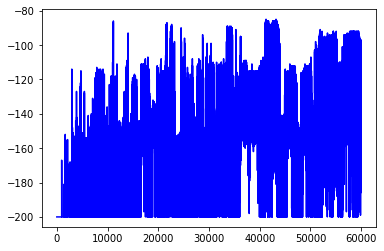

In [ ]:
plt.plot(episodes, scores, 'b')
plt.show()

In [ ]:
show_video()

## Test

In [ ]:
def idx_to_state(env, state):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_distance = (env_high - env_low) / N_idx
    position_idx = int((state[0] - env_low[0]) / env_distance[0])
    velocity_idx = int((state[1] - env_low[1]) / env_distance[1])
    state_idx = position_idx + velocity_idx * N_idx
    return state_idx

In [ ]:
print(":: Testing APP-learning.\n")

# Load the agent
n_states = N_idx**2  # position - 20, velocity - 20
n_actions = 3
q_table = np.load(file="app_q_table.npy")

# Create a new game instance.
env = wrap_env(gym.make("MountainCar-v0"))
n_episode = 10 # test the agent 10times
scores = []

for ep in range(n_episode):
    state = env.reset()
    score = 0

    while True:
        # Render the play
        env.render()

        state_idx = idx_to_state(env, state)

        action = np.argmax(q_table[state_idx])

        next_state, reward, done, _ = env.step(action)
        next_state_idx = idx_to_state(env, next_state)

        score += reward
        state = next_state

        if done:
            print('{} episode | score: {:.1f}'.format(ep + 1, score))
            
            break

env.close()

:: Testing APP-learning.

1 episode | score: -97.0
2 episode | score: -133.0
3 episode | score: -98.0
4 episode | score: -148.0
5 episode | score: -135.0
6 episode | score: -146.0
7 episode | score: -131.0
8 episode | score: -132.0
9 episode | score: -158.0
10 episode | score: -98.0


In [ ]:
show_video()